In [1]:
import dataloader
from dataloader import clean_text, lemmatize_text
from textaug import text_aug
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/nielspace/pytorchenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/nielspace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nielspace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nielspace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

file_list = dataloader.csv_concat(dataloader.DATA_PATH)
df = dataloader.file_structuring(file_list)

code_enc = enc.fit_transform(df.codes)
df["code_enc"] = code_enc

df.head()

,notes,codes,desc,code_enc
0,Patient underwent surgical intervention for St...,M00.0,Staphylococcal arthritis and polyarthritis,0
1,Operative note: Patient presented with Staphyl...,M00.0,Staphylococcal arthritis and polyarthritis,0
2,Operative intervention performed for Staphylo...,M00.0,Staphylococcal arthritis and polyarthritis,0
3,Patient underwent surgical management for Stap...,M00.0,Staphylococcal arthritis and polyarthritis,0
4,Surgical intervention performed for Staphyloco...,M00.0,Staphylococcal arthritis and polyarthritis,0


In [3]:
df.shape

(16779, 4)

In [4]:
print(df.isna().sum())

df.dropna(inplace=True)

print(df.isna().sum())

notes       9
codes       0
desc        0
code_enc    0
dtype: int64
notes       0
codes       0
desc        0
code_enc    0
dtype: int64


In [5]:
len(df[df.duplicated(keep=False)])

2386

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.shape

(15497, 4)

In [8]:
df['Word_Count'] = df['notes'].apply(lambda x: len(x.split()))

<AxesSubplot:>

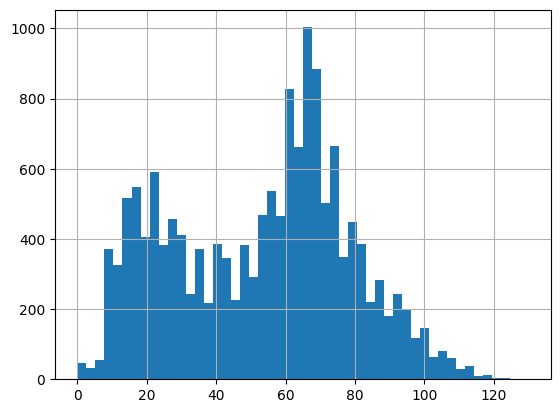

In [9]:
df.Word_Count.hist(bins=50)

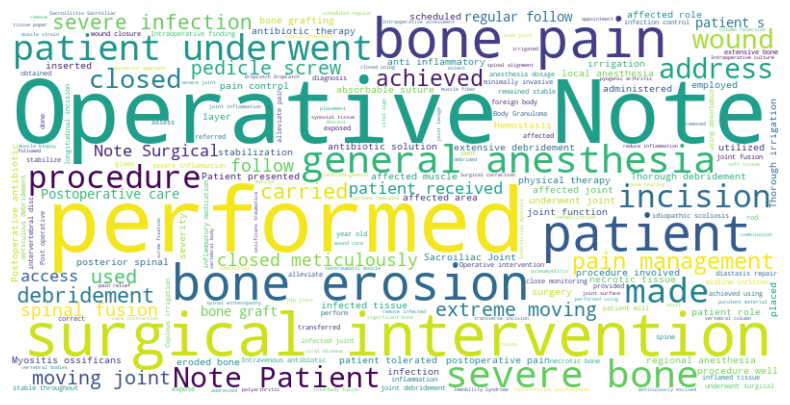

In [ ]:
from wordcloud import WordCloud

# Example text dataset
text = ' '.join(df['notes'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

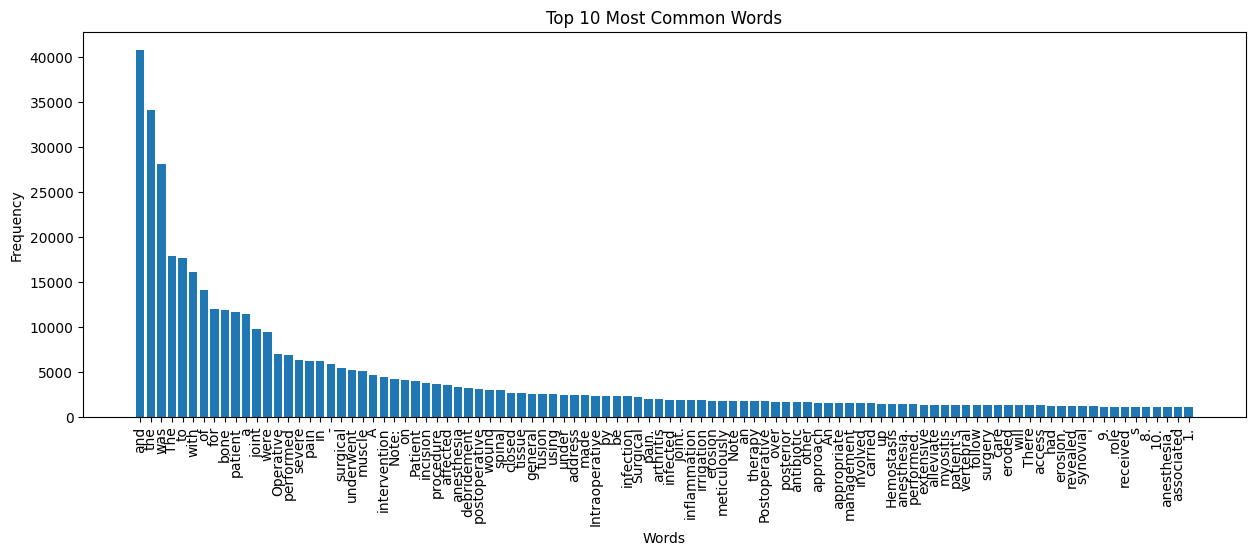

In [11]:
from collections import Counter

# Concatenate all text entries into a single string
text = ' '.join(df['notes'])

# Tokenize the text into individual words
tokens = text.split()

# Count the frequency of each word
word_counts = Counter(tokens)

# Get the most common words and their frequencies
top_words = word_counts.most_common(100)  # Change the number to display more or fewer words

# Extract the words and frequencies
words, frequencies = zip(*top_words)

# Create a bar plot
plt.figure(figsize=(15, 5))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=90)
plt.show()

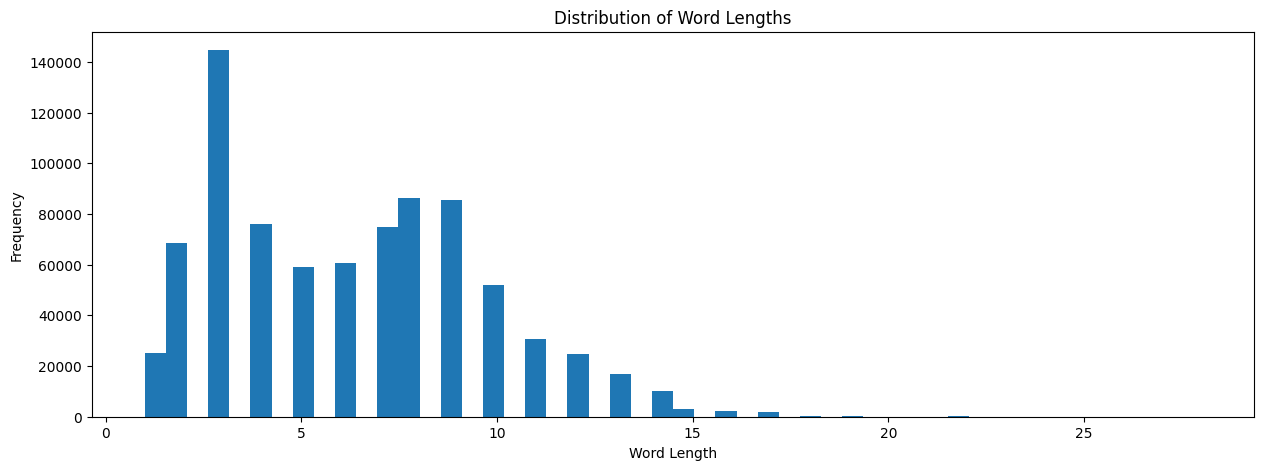

In [12]:
# Concatenate all text entries into a single string
text = ' '.join(df['notes'])

# Tokenize the text into individual words
tokens = text.split()

# Calculate the length of each word
word_lengths = [len(word) for word in tokens]

# Create a histogram
plt.figure(figsize=(15, 5))
plt.hist(word_lengths, bins=50)
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Word Lengths')
plt.show()

In [13]:
import pyLDAvis.gensim_models
from gensim import models
from gensim.corpora import Dictionary
import pyLDAvis.gensim
import nltk

# Concatenate all text entries into a single string
text = ' '.join(df['notes'])

# Tokenize the text into individual words
tokens = nltk.word_tokenize(text)

# Create a Gensim Dictionary
dictionary = Dictionary([tokens])

# Create a Gensim Corpus
corpus = [dictionary.doc2bow(tokens)]

# Define the number of topics for LDA
num_topics = 10

# Create and fit the LDA model
lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

# Visualize the topics
vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)


# Model Engineering

## Data Spliting

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

In [15]:
df = df.sample(frac=1, random_state=23)
size = int(len(df)*0.9)
train = df[:size]
test = df[size:]

In [16]:
words_to_exclude = ['Certainly!']
train = train[~train['notes'].str.contains('|'.join(words_to_exclude))].copy()

word_to_remove = ["1.", "2.", "3.", "4.", "5.", "6.", "7.", "8.", "9.", "10.", 'Certainly!', '00', '00 00', '00 00 00']
for w in word_to_remove:
    train['notes'] = train['notes'].str.replace(w, '')

train = train[train['Word_Count'] >= 10]
train.shape

(13644, 5)

In [17]:
# from embeddings import embeddings

# # from embeddings import embeddings

# (X_train, X_test, y_train, y_test, vectorizer,
# feature_names, pca, labels, category_list) = embeddings.embeddings_gen(train, "notes", "code_enc")

In [18]:
def gen_embeddings(df, 
               X_features=train['notes'],
               y_features=train['code_enc'], 
               test_size=0.2,
               max_features=1000, 
               random_state=23):


    vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), 
                                 max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)

    tfIdfMat  = vectorizer.fit_transform(X_features.tolist())
    feature_names = sorted(vectorizer.get_feature_names_out())



    pca = PCA(n_components=0.95, random_state=23)
    tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
    labels = y_features.tolist()
    category_list = y_features.unique()


    X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, 
                                                        test_size=test_size, 
                                                        stratify=labels,
                                                        random_state=random_state)
    
    return (X_train, X_test, y_train, y_test, vectorizer, feature_names, pca, labels, category_list)
    
    

X_train, X_test, y_train, y_test, vectorizer, feature_names, pca, labels, category_list = gen_embeddings(df)

print(X_train.shape, X_test.shape)

(10915, 575) (2729, 575)


In [19]:
print(f"Feature names or Tokens: {feature_names}")
print(f"Data shape{tfIdfMat.shape}")

Feature names or Tokens: ['abscess', 'abscess evacuation', 'absorbable', 'absorbable sutures', 'access', 'access affected', 'accessed', 'achieve', 'achieved', 'achieved using', 'achieved wound', 'achieved wound closed', 'additional', 'address', 'address bone', 'address severe', 'address severe bone', 'addressed', 'adequate', 'adjusted', 'administered', 'advanced', 'advised', 'affected', 'affected area', 'affected joint', 'affected muscle', 'affected role', 'affected vertebral', 'affecting', 'agent', 'aimed', 'alignment', 'alleviate', 'alleviate pain', 'alleviate severe', 'alleviate severe bone', 'allograft', 'allowing', 'anaesthesia', 'analgesics', 'analysis', 'anesthesia', 'anesthesia administered', 'anesthesia appropriate', 'anesthesia appropriate dosage', 'anesthesia care', 'anesthesia dosage', 'anesthesia intraoperative', 'anesthesia intravenous', 'anesthesia patient', 'anesthetic', 'ankle', 'ankle joint', 'anterior', 'anterior approach', 'anti', 'anti inflammatory', 'anti inflamma

NameError: name 'tfIdfMat' is not defined

## Logistic Regression

In [20]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', 
                         l1_ratio=0.5, max_iter=150, random_state=23).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

In [21]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

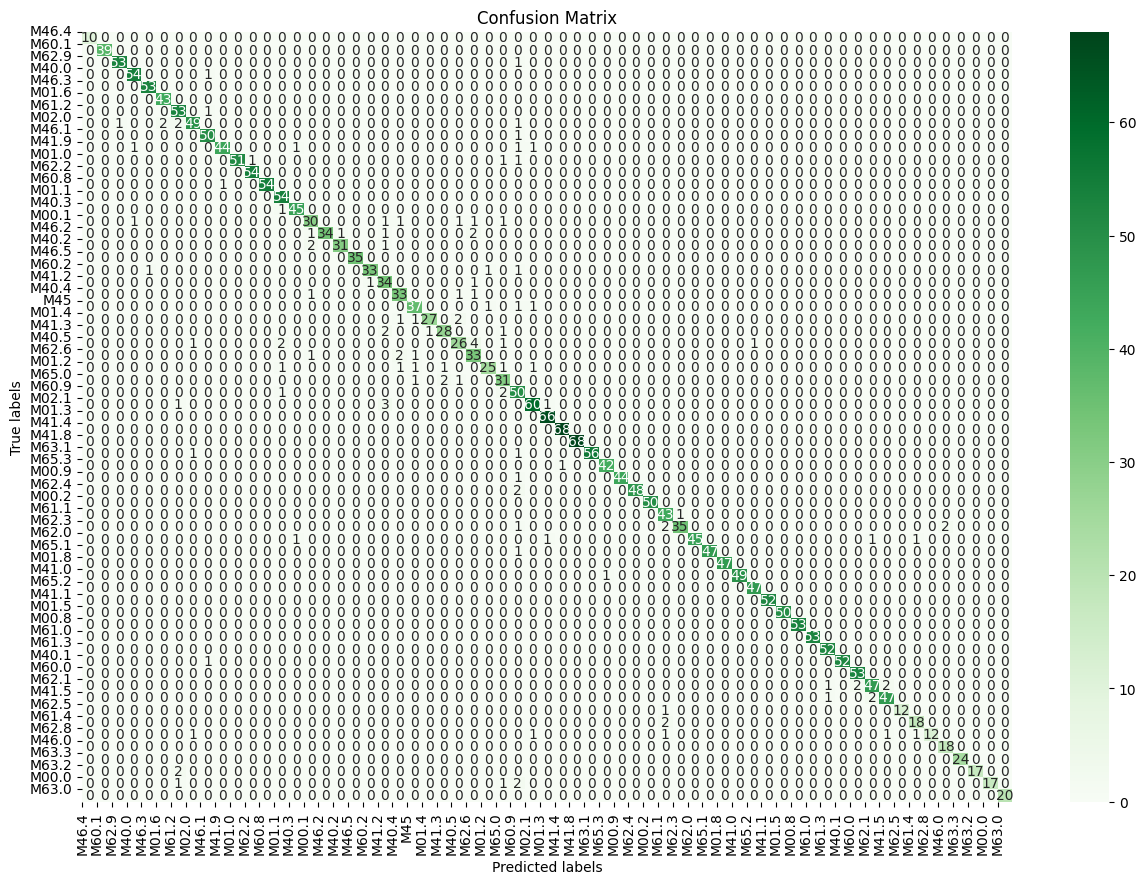

In [22]:
fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix'); 

ax.set_xticks(range(0,len(enc.inverse_transform(labels))))
ax.set_yticks(range(0,len(enc.inverse_transform(labels))))
ax.xaxis.set_ticklabels(enc.inverse_transform(labels)) 
ax.yaxis.set_ticklabels(enc.inverse_transform(labels))

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')  

plt.show()

In [23]:
print(classification_report(y_test,y_test_pred,labels=category_list))

              precision    recall  f1-score   support

          34       1.00      0.97      0.98        58
          37       1.00      0.96      0.98        50
          54       0.94      0.94      0.94        50
          15       0.86      0.83      0.85        36
          33       1.00      1.00      1.00        68
          11       0.98      1.00      0.99        54
          43       1.00      1.00      1.00        47
          13       0.92      1.00      0.96        54
          31       0.97      1.00      0.99        66
          28       0.79      0.89      0.84        35
           5       0.96      1.00      0.98        43
          48       1.00      1.00      1.00        53
          39       0.88      0.98      0.92        44
           6       0.90      0.98      0.94        54
          18       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        39
          32       0.99      1.00      0.99        68
          17       0.97    

In [24]:
clf.predict(X_test[:3]) == y_test[:3]

array([ True,  True,  True])

## Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=None, min_samples_split=2, n_estimators=300, random_state=23)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
labels = category_list
cm_rf = confusion_matrix(y_test, y_test_pred)

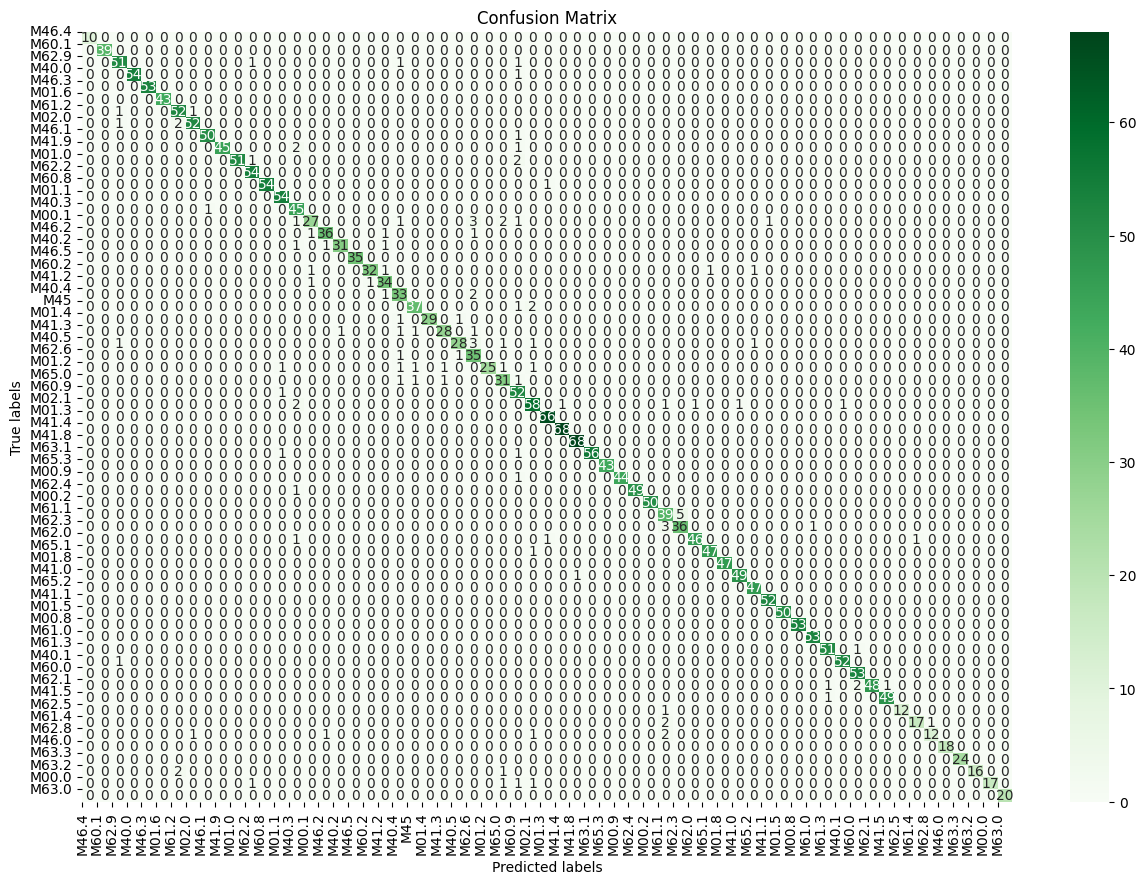

In [27]:
fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm_rf, annot=True, cmap="Greens",ax = ax,fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix'); 

ax.set_xticks(range(0,len(enc.inverse_transform(labels))))
ax.set_yticks(range(0,len(enc.inverse_transform(labels))))
ax.xaxis.set_ticklabels(enc.inverse_transform(labels)) 
ax.yaxis.set_ticklabels(enc.inverse_transform(labels))

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')  

plt.show()

In [28]:
print(classification_report(y_test,y_test_pred,labels=category_list))

              precision    recall  f1-score   support

          34       1.00      0.97      0.98        58
          37       1.00      0.98      0.99        50
          54       0.98      0.98      0.98        50
          15       0.90      0.75      0.82        36
          33       0.99      1.00      0.99        68
          11       0.95      1.00      0.97        54
          43       1.00      1.00      1.00        47
          13       0.95      1.00      0.97        54
          31       0.97      1.00      0.99        66
          28       0.84      0.89      0.86        35
           5       1.00      1.00      1.00        43
          48       1.00      1.00      1.00        53
          39       0.81      0.89      0.85        44
           6       0.93      0.96      0.95        54
          18       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        39
          32       0.99      1.00      0.99        68
          17       0.97    

In [29]:
from sklearn.metrics import accuracy_score, f1_score

rf_predict = rf.predict(X_test)
rf_f1 = f1_score(y_test, rf_predict, average="weighted")
rf_acc = accuracy_score(y_test, rf_predict)

clf_predict = clf.predict(X_test)
clf_f1 = f1_score(y_test, clf_predict, average="weighted")
clf_acc = accuracy_score(y_test, clf_predict)

print(f"Random Forest: {rf_acc}")
print(f"Linear Forest: {clf_acc}")

Random Forest: 0.9563942836203737
Linear Forest: 0.9545621106632466


## XGBoost

In [30]:
import xgboost as xgb

XGB_clf = xgb.XGBClassifier(colsample_bytree = 1.0, 
                            learning_rate = 0.1, 
                            max_depth = 3, 
                            n_estimators = 100, 
                            subsample = 0.9)

XGB_clf.fit(X_train, y_train)
XGB_clf_predict = XGB_clf.predict(X_test)
XGB_clf_f1 = f1_score(y_test, XGB_clf_predict, average="weighted")
XGB_clf_acc = accuracy_score(y_test, XGB_clf_predict)

print(f"XGB: {XGB_clf_acc}")

XGB: 0.9399047270062294


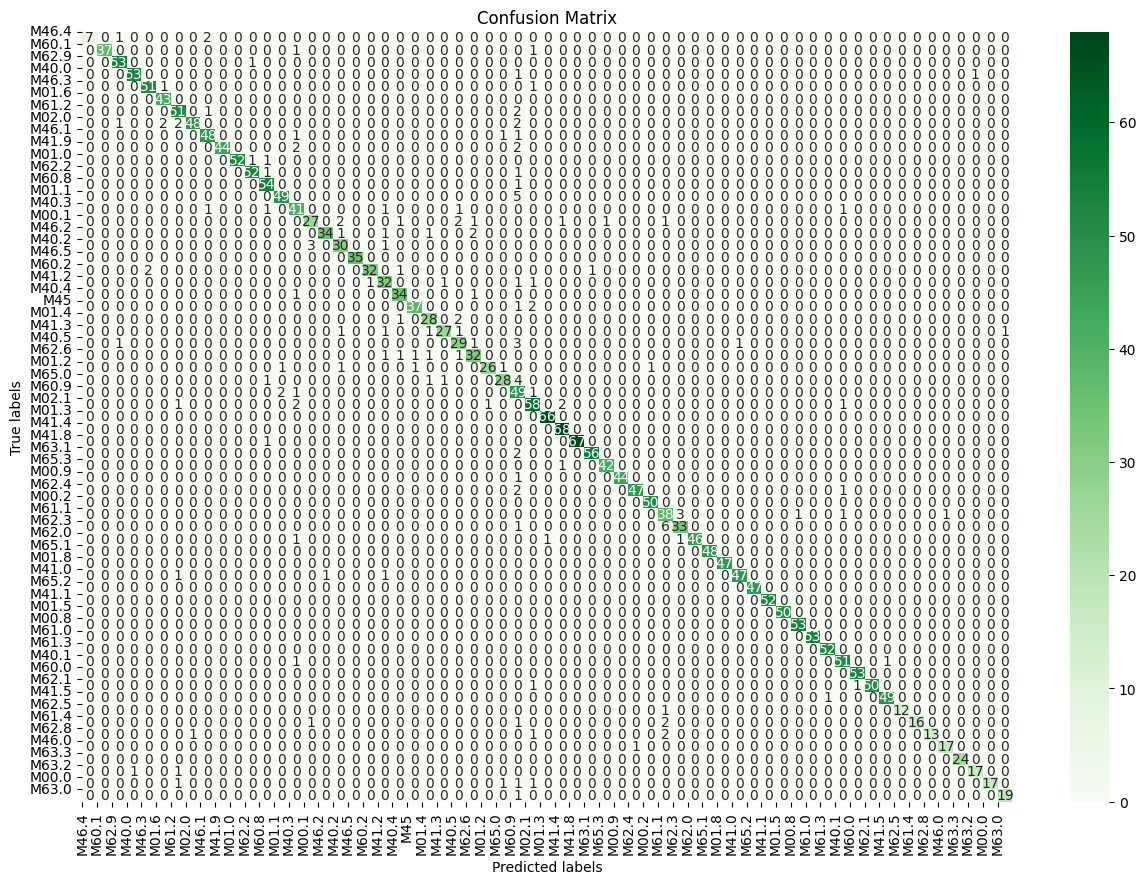

In [31]:
cm_rf = confusion_matrix(y_test, XGB_clf_predict)

fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm_rf, annot=True, cmap="Greens",ax = ax,fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix'); 

ax.set_xticks(range(0,len(enc.inverse_transform(labels))))
ax.set_yticks(range(0,len(enc.inverse_transform(labels))))
ax.xaxis.set_ticklabels(enc.inverse_transform(labels)) 
ax.yaxis.set_ticklabels(enc.inverse_transform(labels))

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')  

plt.show()

In [ ]:
print(classification_report(y_test, XGB_clf_predict,labels=category_list))

# Performance Result

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_models(models, X, y):
    # Define lists to store the results
    model_names = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Iterate over the models
    for name, model in models:
        # Perform cross-validation
        scores = cross_val_score(model, X, y, cv=5)
        
        # Make predictions
        y_pred = model.fit(X, y).predict(X)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average='macro')
        recall = recall_score(y, y_pred, average='macro')
        f1 = f1_score(y, y_pred, average='macro')
        
        # Append the results to the lists
        model_names.append(name)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
    
    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': accuracy_scores,
        'Precision': precision_scores,
        'Recall': recall_scores,
        'F1-Score': f1_scores
    })
    
    return results_df


In [35]:
import pandas as pd

results = evaluate_models(
    [("XGBoost", XGB_clf), ("Random Forest", rf), ("Logistic Regression", clf)], 
    X_test,
    y_test
)

results

,Model,Accuracy,Precision,Recall,F1-Score
0,XGBoost,1.000000,1.000000,1.000000,1.000000
1,Random Forest,1.000000,1.000000,1.000000,1.000000
2,Logistic Regression,0.929645,0.904959,0.883218,0.885473


# Inference Pipeline

In [36]:
print(test.shape)
test.head()

(1550, 5)


,notes,codes,desc,code_enc,Word_Count
3018,Severe bone pain necessitated surgical interve...,M00.8,Arthritis and polyarthritis due to other speci...,3,33
255,9. Operative Note: Patient underwent a vertebr...,M40.5,"Lordosis, unspecified",20,74
330,7.,M65.2,Calcific tendinitis,61,1
390,The surgical intervention was performed for an...,M65.0,Abscess of tendon sheath,59,31
3243,"""There are 9. The patient's right wrist was op...",M01.0,Meningococcal arthritis,5,13


## Data cleaning

In [37]:
words_to_exclude = ['Certainly!']
test = test[~test['notes'].str.contains('|'.join(words_to_exclude))].copy()

word_to_remove = ["1.", "2.", "3.", "4.", "5.", "6.", "7.", "8.", "9.", "10.", 'Certainly!', '00', '00 00', '00 00 00']
for w in word_to_remove:
    test['notes'] = test['notes'].str.replace(w, '')

test = test[test['Word_Count'] >= 10]
test.shape

(1523, 5)

In [39]:
def inference(inp, model):
    
    """
    Parameters: 
        
        inp: string input 
        model: pass the trained model
        
    """
    encoding = vectorizer.transform([f"{inp}"]).toarray()
    pca_trans = pca.transform(encoding)
        
    pred = model.predict(pca_trans)
    result = enc.inverse_transform(pred)

    return result
  

random_number = np.random.randint(0, len(test))
inp = test.iloc[random_number]
    
result = inference(inp.notes, XGB_clf)

print(f"Prediction: {result[0]}")
print(f"Ground Truth: {inp.codes}")

Prediction: M62.1
Ground Truth: M62.1
